# Knowledge Conflicts in Multi-Hop Reasoning — Results Explorer

This notebook lets you interactively explore experiment results, regenerate figures, and run model comparisons.

**Prerequisites:** Run `pip install -r requirements.txt` and ensure `outputs/results/` has experiment data.

In [1]:
import json
import glob
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Add project root to path
sys.path.append(os.path.abspath('..'))

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

## 1. Load All Model Results

In [2]:
RESULTS_DIR = '../outputs/results'

# Auto-discover all model results
all_models = {}
for model_dir in sorted(glob.glob(os.path.join(RESULTS_DIR, '*/experiment.json'))):
    model_id = os.path.basename(os.path.dirname(model_dir))
    with open(model_dir, 'r') as f:
        all_models[model_id] = json.load(f)
    print(f'Loaded: {model_id}')

print(f'\nTotal models: {len(all_models)}')

Loaded: llama-3.1-8b-instant
Loaded: llama-3.3-70b-versatile

Total models: 2


## 2. Summary Table — All Models, All Conditions

In [3]:
conditions = ['no_conflict', 'conflict_hop1', 'conflict_hop2']
cond_labels = {'no_conflict': 'No Conflict', 'conflict_hop1': 'Conflict@Hop1', 'conflict_hop2': 'Conflict@Hop2'}

rows = []
for model_id, data in all_models.items():
    metrics = data['metrics']
    for cond in conditions:
        if cond not in metrics:
            continue
        m = metrics[cond]
        rows.append({
            'Model': model_id,
            'Condition': cond_labels[cond],
            'N': m['n'],
            'Accuracy': f"{m['accuracy']:.1%}",
            'CFR': f"{m['context_following_rate']:.1%}" if m['context_following_rate'] > 0 else '-',
            'POR': f"{m['parametric_override_rate']:.1%}" if m['parametric_override_rate'] > 0 else '-',
        })

df_summary = pd.DataFrame(rows)
df_summary

,Model,Condition,N,Accuracy,CFR,POR
0,llama-3.1-8b-instant,No Conflict,100,53.0%,-,-
1,llama-3.1-8b-instant,Conflict@Hop1,100,37.0%,12.0%,37.0%
2,llama-3.1-8b-instant,Conflict@Hop2,100,30.0%,18.0%,30.0%
3,llama-3.3-70b-versatile,No Conflict,100,71.0%,-,-
4,llama-3.3-70b-versatile,Conflict@Hop1,100,42.0%,14.0%,42.0%
5,llama-3.3-70b-versatile,Conflict@Hop2,100,45.0%,19.0%,45.0%


## 3. Accuracy Comparison Chart (Per Model)

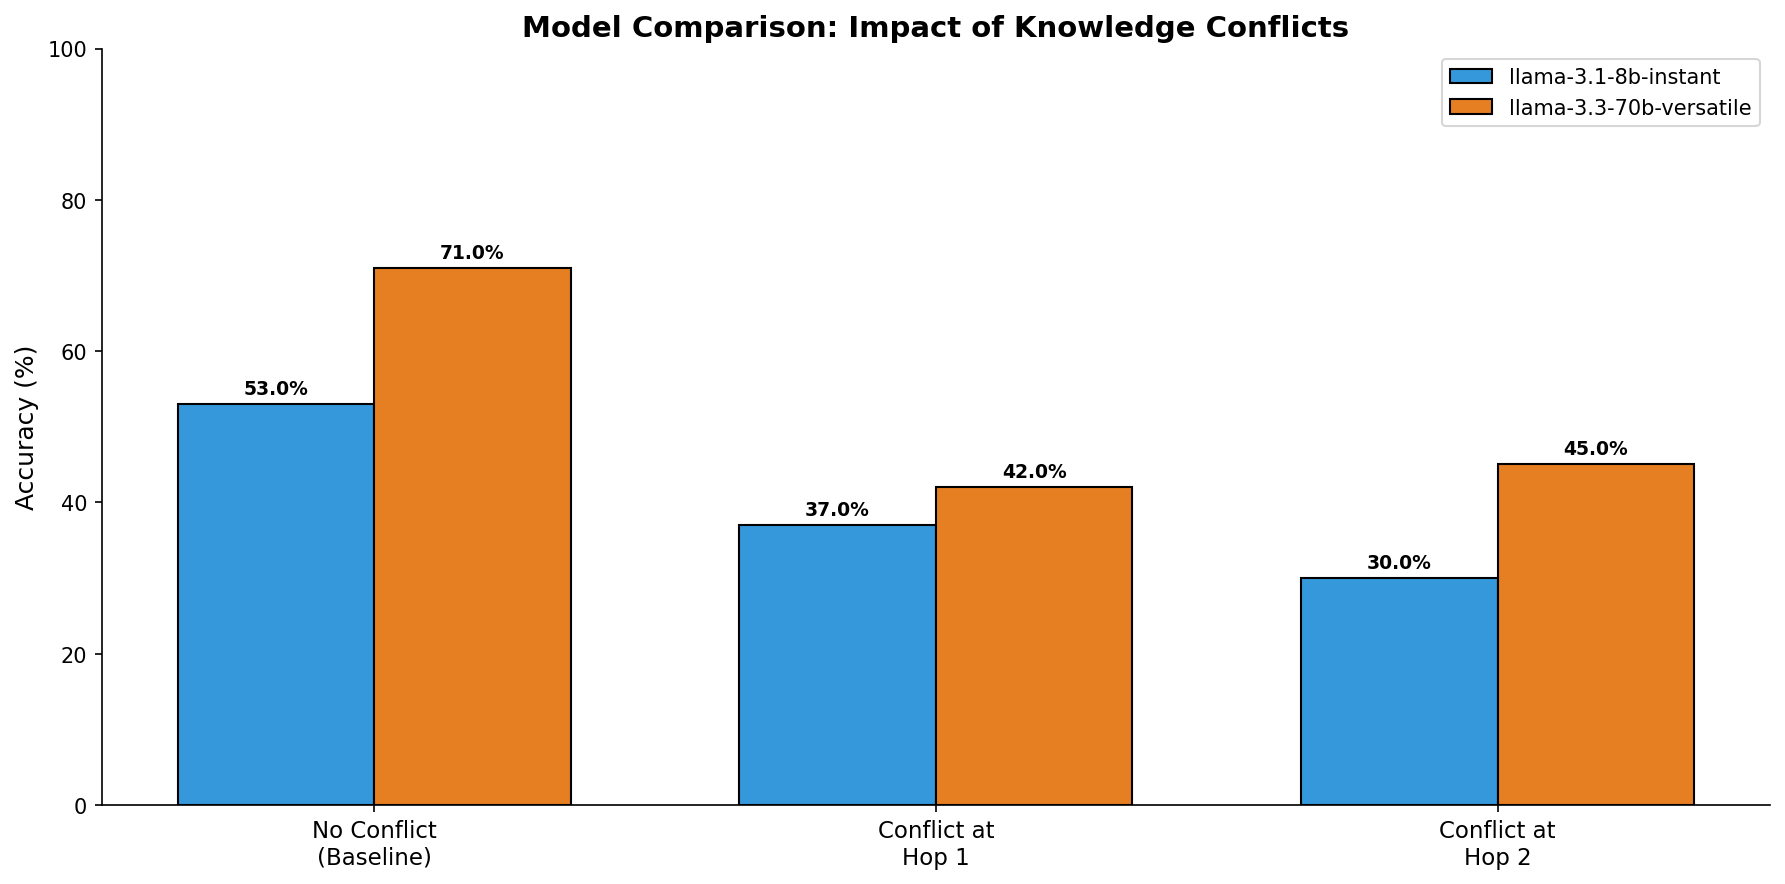

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['No Conflict\n(Baseline)', 'Conflict at\nHop 1', 'Conflict at\nHop 2']
x = np.arange(len(labels))
n_models = len(all_models)
width = 0.7 / n_models
colors = ['#3498db', '#e67e22', '#2ecc71', '#9b59b6']

for idx, (model_id, data) in enumerate(all_models.items()):
    metrics = data['metrics']
    accs = [metrics[c]['accuracy'] * 100 if c in metrics else 0 for c in conditions]
    offset = (idx - (n_models - 1) / 2) * width
    bars = ax.bar(x + offset, accs, width, label=model_id,
                  color=colors[idx % len(colors)], edgecolor='black', linewidth=1)
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Comparison: Impact of Knowledge Conflicts', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(0, 100)
ax.legend(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## 4. Statistical Tests Between Models

In [5]:
model_ids = list(all_models.keys())

if len(model_ids) >= 2:
    m1, m2 = model_ids[0], model_ids[1]
    met1, met2 = all_models[m1]['metrics'], all_models[m2]['metrics']

    stat_rows = []
    for cond in conditions:
        if cond not in met1 or cond not in met2:
            continue
        a1, n1 = met1[cond]['accuracy'], met1[cond]['n']
        a2, n2 = met2[cond]['accuracy'], met2[cond]['n']
        ct = [[int(a1*n1), n1 - int(a1*n1)],
              [int(a2*n2), n2 - int(a2*n2)]]
        chi2, p_val, _, _ = stats.chi2_contingency(ct)
        stat_rows.append({
            'Condition': cond_labels[cond],
            f'{m1} Acc': f'{a1:.1%}',
            f'{m2} Acc': f'{a2:.1%}',
            'Chi2': f'{chi2:.2f}',
            'p-value': f'{p_val:.4f}',
            'Significant (p<0.05)': 'Yes' if p_val < 0.05 else 'No'
        })

    df_stats = pd.DataFrame(stat_rows)
    display(df_stats)
else:
    print('Need 2+ models for comparison. Run experiments/run_model_comparison.py first.')

,Condition,llama-3.1-8b-instant Acc,llama-3.3-70b-versatile Acc,Chi2,p-value,Significant (p<0.05)
0,No Conflict,53.0%,71.0%,6.13,0.0133,Yes
1,Conflict@Hop1,37.0%,42.0%,0.33,0.5629,No
2,Conflict@Hop2,30.0%,45.0%,4.18,0.0409,Yes


## 5. Per-Model Behavior Breakdown (CFR vs POR)

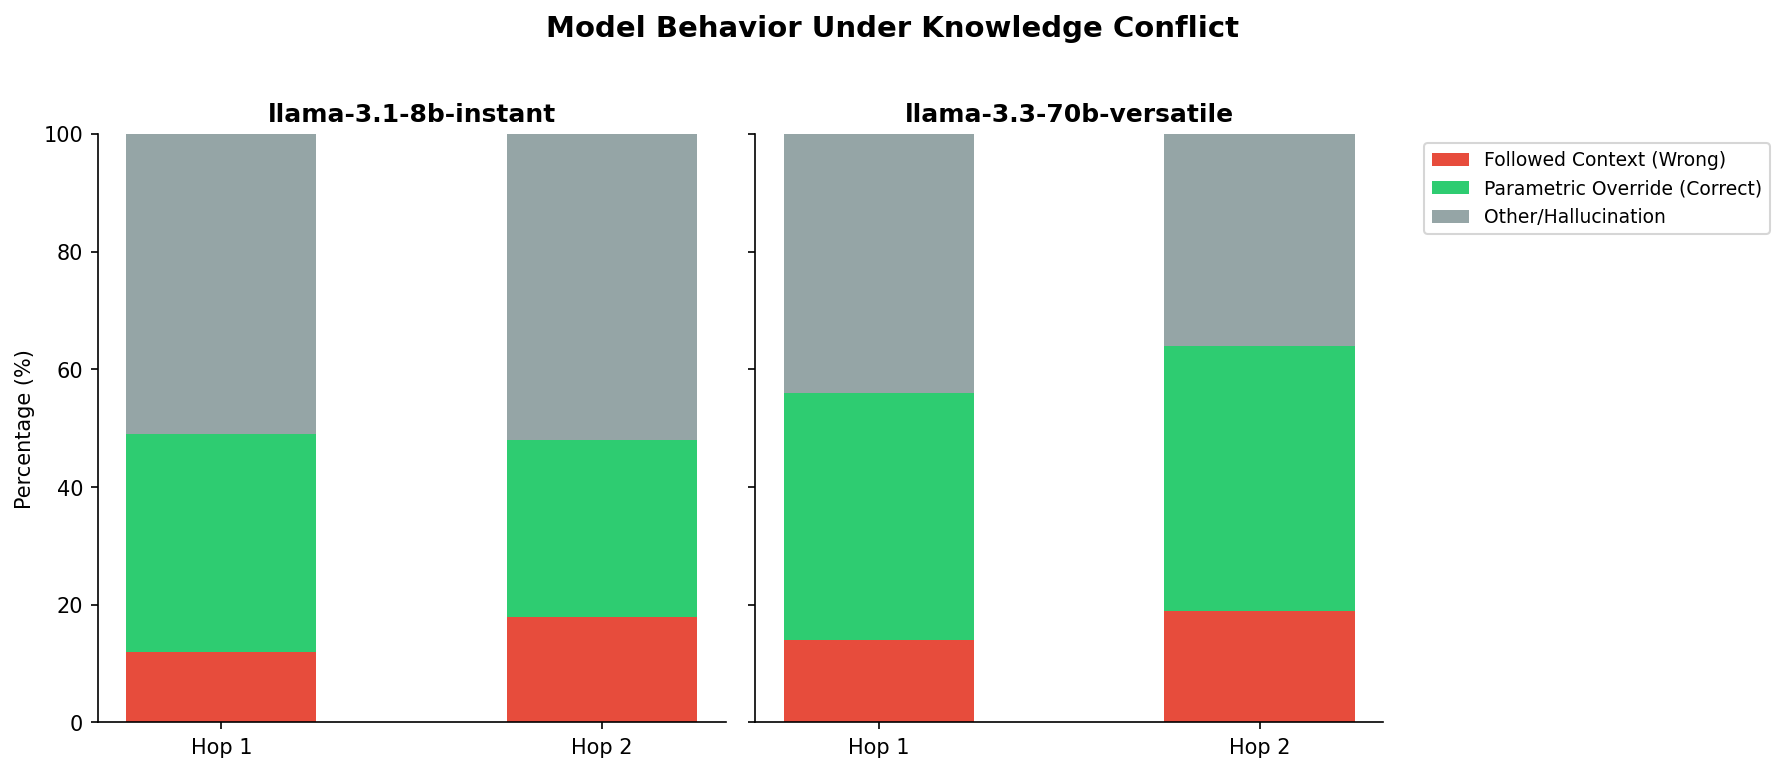

In [6]:
fig, axes = plt.subplots(1, len(all_models), figsize=(6 * len(all_models), 5), sharey=True)
if len(all_models) == 1:
    axes = [axes]

for ax, (model_id, data) in zip(axes, all_models.items()):
    metrics = data['metrics']
    conflict_conds = ['conflict_hop1', 'conflict_hop2']
    bar_labels = ['Hop 1', 'Hop 2']

    cfr = [metrics[c]['context_following_rate'] * 100 for c in conflict_conds]
    por = [metrics[c]['parametric_override_rate'] * 100 for c in conflict_conds]
    other = [100 - cfr[i] - por[i] for i in range(len(conflict_conds))]

    x = np.arange(len(bar_labels))
    w = 0.5
    ax.bar(x, cfr, w, label='Followed Context (Wrong)', color='#e74c3c')
    ax.bar(x, por, w, bottom=cfr, label='Parametric Override (Correct)', color='#2ecc71')
    ax.bar(x, other, w, bottom=[cfr[i]+por[i] for i in range(len(conflict_conds))],
           label='Other/Hallucination', color='#95a5a6')

    ax.set_title(model_id, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bar_labels)
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('Percentage (%)')
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.suptitle('Model Behavior Under Knowledge Conflict', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Inspect Individual Examples

Browse raw predictions for any model/condition.

In [7]:
# Pick a model and condition to inspect
MODEL = list(all_models.keys())[0]  # change index to pick model
CONDITION = 'conflict_hop1'         # no_conflict, conflict_hop1, conflict_hop2

results = all_models[MODEL]['raw_results'][CONDITION]

df_raw = pd.DataFrame(results)
print(f'Model: {MODEL} | Condition: {CONDITION} | Total: {len(df_raw)}')
print(f'Correct: {df_raw["correct"].sum()} | Wrong: {(~df_raw["correct"]).sum()}')
print()

# Show first 5 wrong answers
wrong = df_raw[~df_raw['correct']].head(5)
for _, row in wrong.iterrows():
    print(f"Q: {row['question'][:100]}...")
    print(f"  Gold: {row['gold']}")
    print(f"  Predicted: {row['predicted'][:80]}...")
    if 'fake' in row and pd.notna(row.get('fake')):
        print(f"  Fake: {row['fake']}")
        print(f"  Followed context: {row['followed_context']}")
    print()

Model: llama-3.1-8b-instant | Condition: conflict_hop1 | Total: 100
Correct: 37 | Wrong: 63

Q: What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tel...
  Gold: Chief of Protocol
  Predicted: ** United States ambassador to Ghana and to Czechoslovakia...
  Fake: David Lee
  Followed context: False

Q: What science fantasy young adult series, told in first person, has a set of companion books narratin...
  Gold: Animorphs
  Predicted: However...
  Fake: James Wilson
  Followed context: False

Q: The director of the romantic comedy "Big Stone Gap" is based in what New York city?...
  Gold: Greenwich Village, New York City
  Predicted: However, if we were to make an educated guess, we might consider that the questi...
  Fake: Berlin
  Followed context: True

Q: The arena where the Lewiston Maineiacs played their home games can seat how many people?...
  Gold: 3,677 seated
  Predicted: The arena where the Lewiston Maineiacs played their home ga

## 7. Run a New Model (Optional)

To add another model to the comparison, edit the `MODELS` list in `experiments/run_model_comparison.py` and run it. The script will skip models that already have results.

```bash
# From project root:
python experiments/run_model_comparison.py
```

Then re-run this notebook — new model results will be auto-discovered.

## 8. Qualitative Examples

In [8]:
qual_path = '../outputs/qualitative_examples.json'
if os.path.exists(qual_path):
    with open(qual_path, 'r', encoding='utf-8') as f:
        examples = json.load(f)
    
    for ex in examples:
        print(f"=== Example {ex['id']}: {ex['question'][:80]}... ===")
        print(f"  Conflict at: {ex['conflict_position']}")
        print(f"  Injected: \"{ex['original_answer']}\" -> \"{ex['injected_fake']}\"")
        print(f"  Baseline answer: {ex['baseline_answer'][:60]}...")
        print(f"  Conflict answer: {ex['conflict_answer'][:60]}...")
        print(f"  Error type: {ex['error_type']}")
        print()
else:
    print('No qualitative examples found. Run: python experiments/extract_qualitative.py')

=== Example 1: What screenwriter with credits for "Evolution" co-wrote a film starring Nicolas ... ===
  Conflict at: hop1
  Injected: "David Weissman" -> "Maria Garcia"
  Baseline answer: Therefore, the answer to the question is **David Weissman**....
  Conflict answer: 3. **Provide the answer**: Given the information provided an...
  Error type: followed_context

=== Example 2: 2014 S/S is the debut album of a South Korean boy group that was formed by who?... ===
  Conflict at: hop2
  Injected: "YG Entertainment" -> "John Smith"
  Baseline answer: Therefore, the answer to the question "2014 S/S is the debut...
  Conflict answer: Therefore, the answer to the question is: Jennifer Martinez....
  Error type: followed_context

=== Example 3: Who was known by his stage name Aladin and helped organizations improve their pe... ===
  Conflict at: hop2
  Injected: "Eenasul Fateh" -> "Michael Brown"
  Baseline answer: The final answer is: Eenasul Fateh (Aladin)...
  Conflict answer: Therefore,